# Simple synchronism test of the XCOM block

The general idea is that the boards are locked to a common reference, a "PPS" signal comming from a GPS for example. In this case we generate a false PPS in the HP 8110A generator. It has two synchronous channels and give us a "typical" PPS signal (200ms high, 800ms low). There is a "leader" board and a "follower" board. The boards are inter-connected trhough xcom blocks. 

### hardware setup
I'm using ZCU111s because I have two of them. The RF cabling is similar to what we use for the standard demos (DAC 229_3 to ADC 224_0, DAC 229_2 to ADC 224_1), except that the second loopback goes between boards (DAC 229_2 of each board to ADC 224_1 of the other).

Both boards need to be locked to a common reference. The ZCU111 needs a 12.8 MHz reference (see https://docs.qick.dev/latest/_autosummary/qick.qick.html#qick.qick.QickSoc) at somewhere above 0 dBm.

The sync is done with a single wire, PMOD0_0 of the "leader" board to PMOD1_0 of the "follower" board.
No reason why we couldn't wire multiple followers to a single leader, though eventually the signal integrity might be a problem.

# First test the generators and acquisition
The idea here is to test the loopback connection like in 00_intro.ipynb

In [28]:
# jupyter setup boilerplate
%matplotlib inline
import time
import matplotlib.pyplot as plt
import numpy as np
from qick import *
# for now, all the tProc v2 classes needto be individually imported (can't use qick.*)
# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

In [29]:
qick.get_version()

'0.2.343'

In [30]:
soc = QickSoc('./tprocv2r21_standard.bit')
soccfg = soc
#print(soccfg)

In [31]:
# ZCU216 standard FW, full-speed gen
GEN_CH = 0
RO_CH = 0
TRIG_TIME = 0.40
FREQ = 500

In [32]:
class MultiPulseProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="myflattop", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mygaus", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=0.2, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0,
                      )

        self.add_pulse(ch=gen_ch, name="myflattop2", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=90,
                       gain=1.0, 
                      )

        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)
        # send the config to the dynamic RO
        self.send_readoutconfig(ch=ro_ch, name="myro", t=0)
        
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)

        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=0.4)
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0.8)
        self.pulse(ch=cfg['gen_ch'], name="myflattop2", t=1.2)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=1.6)
        
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 1.9,
         }

#prog = MultiPulseProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
#
#iq_list = prog.acquire_decimated(soc, soft_avgs=10)
#t = prog.get_time_axis(ro_index=0)
#
#plt.plot(t, iq_list[0][:,0], label="I value")
#plt.plot(t, iq_list[0][:,1], label="Q value")
#plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
#plt.legend()
#plt.ylabel("a.u.")
#plt.xlabel("us");

In [33]:
soc.xcom_0.xcom_cfg = 4

In [34]:
soc.xcom_0.set_local_id(5)
#soc.xcom_1.print_status()
soc.xcom_0.print_axi_regs()

---------------------------------------------
--- AXI Registers
 xcom_ctrl          32 - 0000_0000_0000_0000_0000_0000_0010_0000
  xcom_cfg           4 - 0000_0000_0000_0000_0000_0000_0000_0100
   axi_dt1           5 - 0000_0000_0000_0000_0000_0000_0000_0101
   axi_dt2           0 - 0000_0000_0000_0000_0000_0000_0000_0000
  axi_addr           0 - 0000_0000_0000_0000_0000_0000_0000_0000
  board_id           5 - 0000_0000_0000_0000_0000_0000_0000_0101
      flag           0 - 0000_0000_0000_0000_0000_0000_0000_0000
       dt1           0 - 0000_0000_0000_0000_0000_0000_0000_0000
       dt2           0 - 0000_0000_0000_0000_0000_0000_0000_0000
       mem           0 - 0000_0000_0000_0000_0000_0000_0000_0000
     rx_dt           0 - 0000_0000_0000_0000_0000_0000_0000_0000
     tx_dt           0 - 0000_0000_0000_0000_0000_0000_0000_0000
    status     2818048 - 0000_0000_0010_1011_0000_0000_0000_0000
     debug           0 - 0000_0000_0000_0000_0000_0000_0000_0000


In [35]:
soc.xcom_0.run_cmd(soc.xcom_0.opcodes['XCOM_WRITE_MEM'], 3, 0x5001)

In [36]:
print("{0:5s} {2:12s}".format('addr','\t','xcom_0_mem'))
for i in range(16):
    soc.xcom_0.axi_addr = i
    #soc.xcom_1.axi_addr = i
    print("{0:3d} {2:12d}".format(soc.xcom_0.axi_addr, '\t', soc.xcom_0.mem))
    soc.xcom_0.mem

addr  xcom_0_mem  
  0            0
  1            0
  2            0
  3        20481
  4            0
  5            0
  6            0
  7            0
  8            0
  9            0
 10            0
 11            0
 12            0
 13            0
 14            0
 15            0


In [24]:
soc.xcom_0.run_cmd(soc.xcom_0.opcodes['XCOM_QCTRL'], 4, 6) #7 means proc_stop

  0%|          | 0/1 [00:00<?, ?it/s]

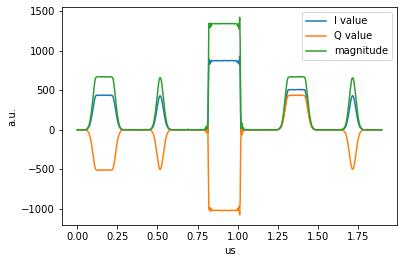

In [45]:
prog = MultiPulseProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

#soc.xcom_0.run_cmd(soc.xcom_0.opcodes['XCOM_QCTRL'], 4, 7) #7 means proc_stop
#soc.xcom_0.run_cmd(11, 4, 7) #7 means proc_stop
iq_list = prog.acquire_decimated(soc, soft_avgs=10, start_src='external')
#iq_list = prog.acquire_decimated(soc, soft_avgs=10, start_src='internal')
#time.sleep(0.1)
soc.xcom_0.run_cmd(soc.xcom_0.opcodes['XCOM_QRST_SYNC'], 4, 3)
#soc.xcom_0.run_cmd(soc.xcom_0.opcodes['XCOM_QCTRL'], 4, 6) #7 means proc_stop

t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

### Python async: running programs concurrently
Need to run programs on both boards at the same time.
We can wrap acquire_decimated() in an async function: https://stackoverflow.com/questions/43241221/how-can-i-wrap-a-synchronous-function-in-an-async-coroutine

It's important that the follower should be started first so it's listening for its start signal before the leader sends it. So we delay starting the leader by 0.1 second.

This doesn't do the right thing in the case of multiple soft_avgs: in this case both boards are started and stopped multiple times, once for each soft_avg, and you need to make sure the follower is always started first, but we are only synchronizing the Python code outside the soft_avgs loop. Will do.

In [331]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *

In [332]:
import asyncio
import nest_asyncio
nest_asyncio.apply()
loop = asyncio.get_event_loop()
import functools

async def wrap_acquire_decimated(loop, isLeader, prog, soc):
    if isLeader:
        start_src = 'internal'
        print("waiting to start leader")
        await asyncio.sleep(0.1)
        print("starting leader")
    else:
        start_src = 'external'
        print("follower ready")
    # use functools.partial to pass keyword arguments: https://docs.python.org/3/library/asyncio-eventloop.html#asyncio-pass-keywords
    result = await loop.run_in_executor(None, functools.partial(prog.acquire_decimated, soc, progress=True, start_src=start_src))
    if isLeader:
        print("leader done")
    else:
        print("follower done")
    return result

async def run_multiboard():
    async with asyncio.TaskGroup() as tg:
        tasks = []
        for i, (soc, soccfg) in enumerate(proxies):
            tasks.append(tg.create_task(wrap_acquire_decimated(loop, i==0, progs[i], soc)))
    results = [task.result() for task in tasks]
    return results
    print("done")

## tProc v1
Start with tProc v1 because we know the external start works . . . the standard firmware is fine.

On each board (`qick1` for leader, `qick2` for follower):
```
from qick.pyro import start_server
start_server(ns_host="linux-139028.dhcp.fnal.gov", ns_port=8888, proxy_name="qick1",
             external_clk=True,
            )
```

In [ ]:
from qick.pyro import make_proxy
proxies = []
for name in ['qick1', 'qick2']:
    proxies.append(make_proxy(ns_host="localhost", ns_port=8888, proxy_name=name))

for soc, soccfg in proxies:
    print(soccfg)

In [334]:
GEN_CHS = [6, 5]
RO_CHS = [0, 1]
TRIG_TIME = 120 # tProc ticks
FREQ = 500

In [335]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg
        for gen_ch in cfg["gen_chs"]:
            self.declare_gen(ch=gen_ch, nqz=1)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=cfg["ro_len"],
                                 freq=cfg["freq"], gen_ch=cfg["gen_chs"][0])

        freq = self.freq2reg(cfg["freq"],gen_ch=cfg["gen_chs"][0], ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["gen_phase"], gen_ch=cfg["gen_chs"][0])
        gain = cfg["gen_gain"]
        for gen_ch in cfg["gen_chs"]:
            self.set_pulse_registers(ch=gen_ch, freq=freq, phase=phase, gain=gain,
                                         style="const", length=cfg["pulse_len"])
        if cfg['send_start']:
            self.synci(200)  # give processor some time to set registers
            self.trigger(pins=[0], t=0) # output a pulse on PMOD0_0, to trigger the follower
            self.synci(cfg['leader_delay']) # give follower time to catch up
        self.synci(200)  # give processor some time to set registers
    
    def body(self):
        self.trigger(adcs=self.cfg["ro_chs"],
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        for gen_ch in self.cfg["gen_chs"]:
            self.pulse(ch=gen_ch)
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

config={"gen_chs":GEN_CHS, # --Fixed
        "ro_chs":RO_CHS, # --Fixed
        "leader_delay": 10, # [tProc ticks]
        "relax_delay":1.0, # --us
        "gen_phase":0, # --degrees
        "pulse_len":10, # [gen ticks]
        "ro_len": 50, # [RO ticks]
        "gen_gain": 30000, # [DAC units]
        "freq": FREQ, # [MHz]
        "adc_trig_offset": TRIG_TIME, # [tProc ticks]
        "send_start": False,
        "reps": 1, # --Fixed
        "soft_avgs":1
       }

### one board at a time

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

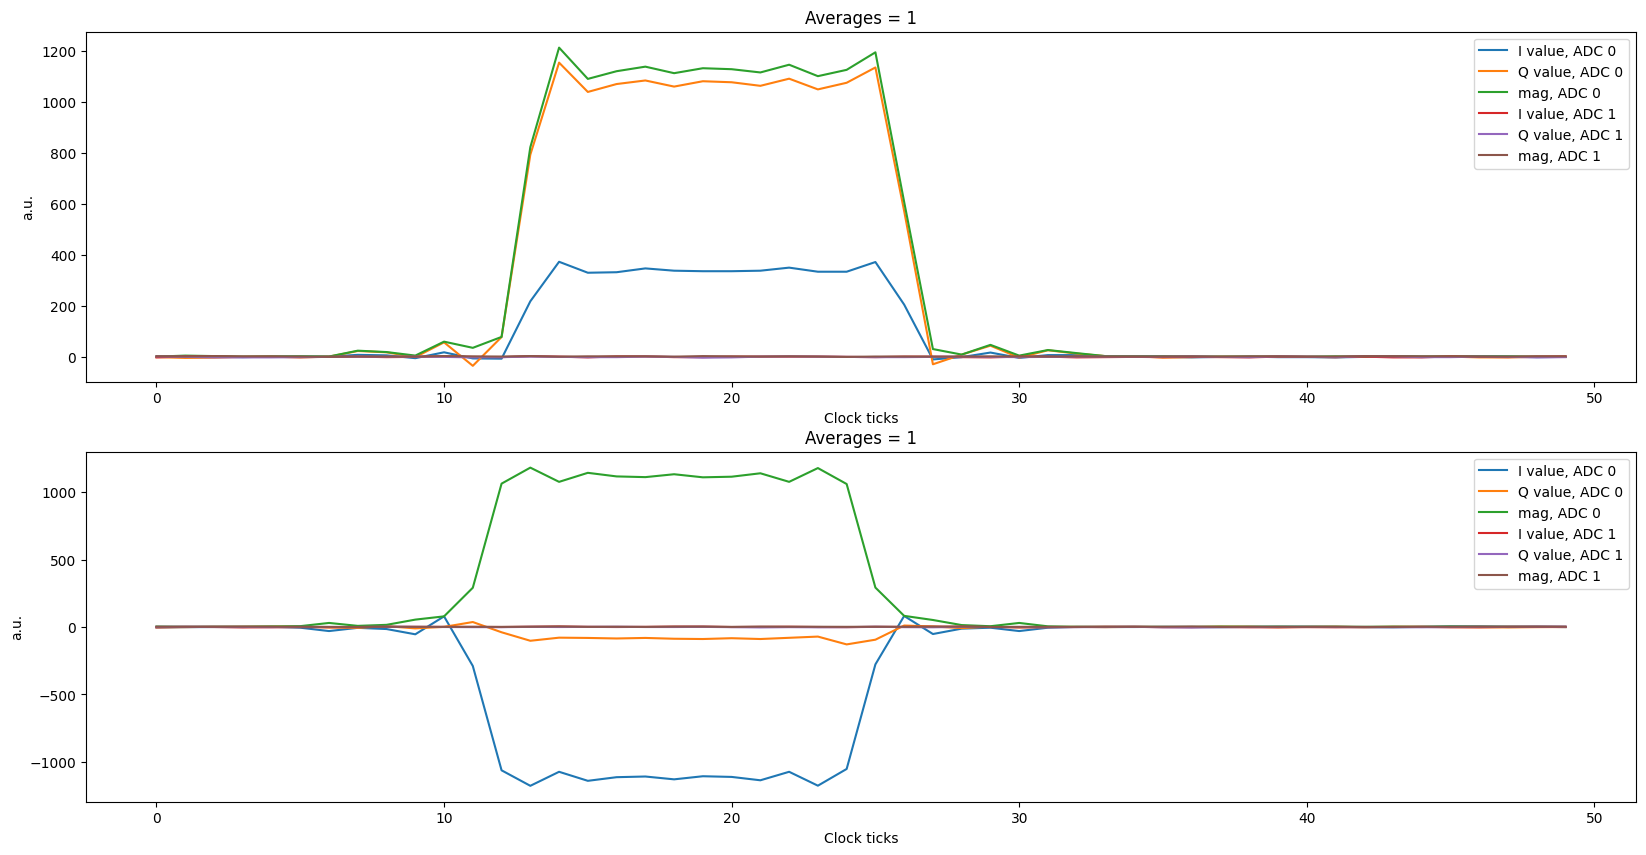

In [336]:
progs = []
config['send_start'] = False
for i, (soc, soccfg) in enumerate(proxies):
    progs.append(LoopbackProgram(soccfg, config))
    
iq_lists = []
for i, (soc, soccfg) in enumerate(proxies):
    iq_lists.append(progs[i].acquire_decimated(soc, progress=True))

fig, axes = plt.subplots(len(iq_lists), 1, figsize=(20,10))
for i, iq_list in enumerate(iq_lists):
    plot = axes[i]
    for ii, iq in enumerate(iq_list):
        plot.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
        plot.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
        plot.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
    plot.set_ylabel("a.u.")
    plot.set_xlabel("Clock ticks")
    plot.set_title("Averages = " + str(config["soft_avgs"]))
    plot.legend();

### synchronized
Adjust the `leader_delay` to get the pulses aligned.

Run repeatedly to see that the delay between the two pulses seen by either board stays fixed (the absolute time will jitter a little, because the readout and generator clocks are different).

waiting to start leader
follower ready


  0%|          | 0/1 [00:00<?, ?it/s]

starting leader


  0%|          | 0/1 [00:00<?, ?it/s]

follower done
leader done


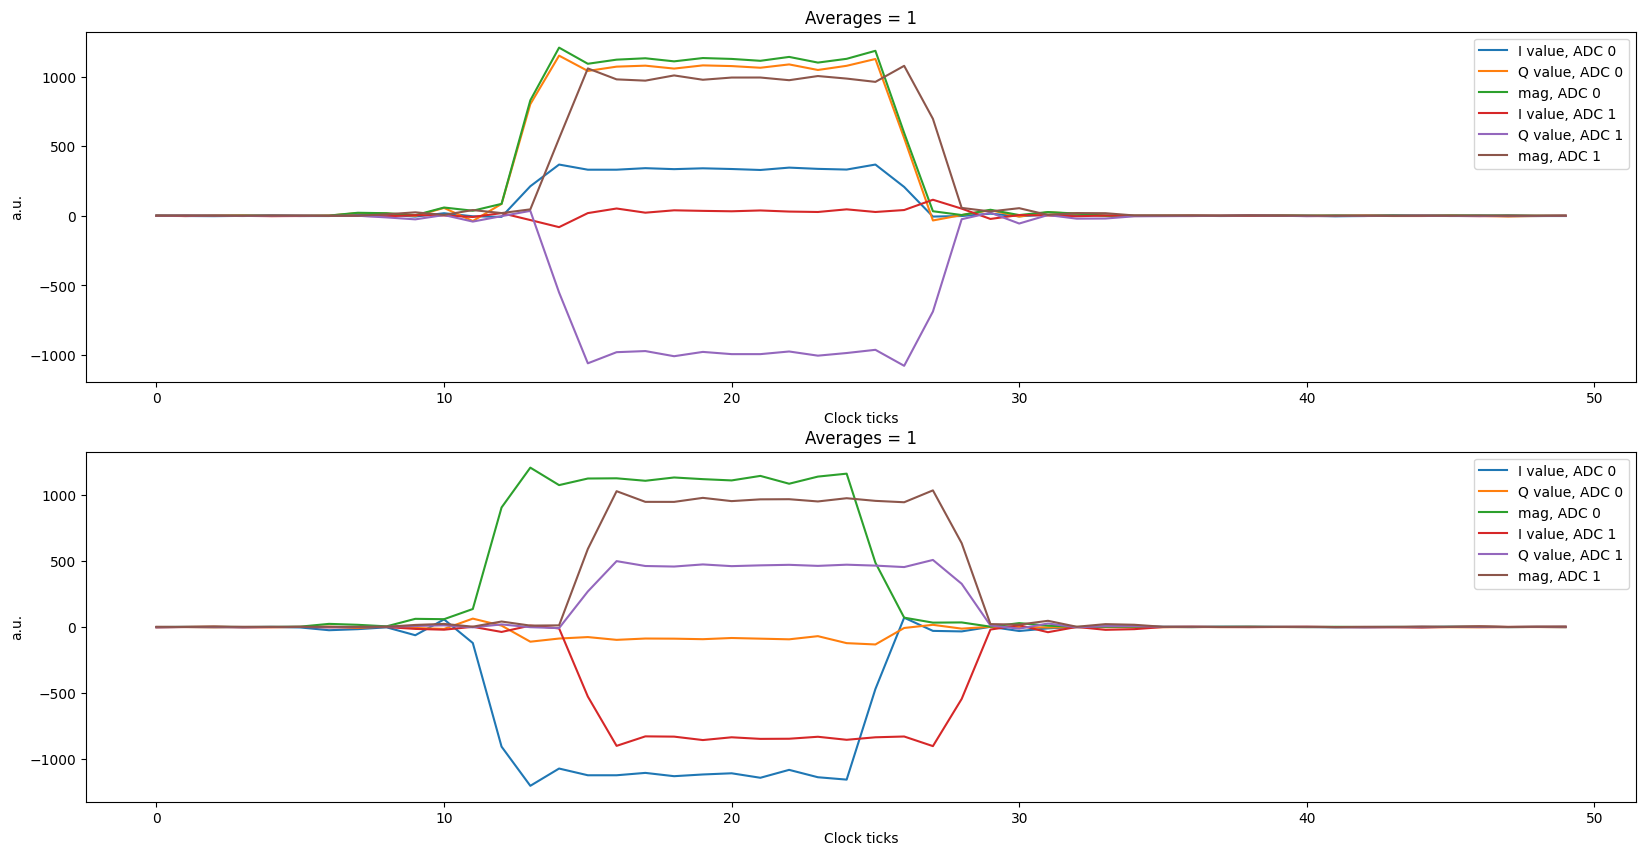

In [342]:
config['leader_delay'] = 15
config['soft_avgs'] = 1

progs = []
for i, (soc, soccfg) in enumerate(proxies):
    config['send_start'] = (i==0)
    progs.append(LoopbackProgram(soccfg, config))

iq_lists = asyncio.run(run_multiboard())

fig, axes = plt.subplots(len(iq_lists), 1, figsize=(20,10))
for i, iq_list in enumerate(iq_lists):
    plot = axes[i]
    for ii, iq in enumerate(iq_list):
        plot.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
        plot.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
        plot.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
    plot.set_ylabel("a.u.")
    plot.set_xlabel("Clock ticks")
    plot.set_title("Averages = " + str(config["soft_avgs"]))
    plot.legend();

## tProc v2
The start pulse is launched on the leader's tProc dispatcher clock and latched on the follower's tProc core clock; the follower's core then starts the dispatcher.
For this to be jitter-free, the dispatcher clock should be an integer multiple of the core clock. This isn't true in the standard firmware, which currently generates the core clock from the PS clock - but easy to change.

Standard firmware with tProc r23 , which is needed for external start to work: https://s3df.slac.stanford.edu/people/meeg/qick/tprocv2/2025-06-02_111_tprocv2r23_standard/

Jitter-free (but this firmware crashes - need to debug): 
https://s3df.slac.stanford.edu/people/meeg/qick/tprocv2/2025-06-02_111_tprocv2r23_standard/

On each board (`qick1` for leader, `qick2` for follower):
```
from qick.pyro import start_server
start_server(ns_host="linux-139028.dhcp.fnal.gov", ns_port=8888, proxy_name="qick1",
             external_clk=True,
             bitfile="/data/fw/2025-06-02_111_tprocv2r23_standard/qick_111.bit"
            )
```

In [344]:
from qick.pyro import make_proxy
proxies = []
for name in ['qick1', 'qick2']:
    proxies.append(make_proxy(ns_host="localhost", ns_port=8888, proxy_name=name))

for soc, soccfg in proxies:
    print(soccfg)

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
qick1 PYRO:obj_98f5e99626da4b43b4b6ea926e26fb00@131.225.82.194:45227
qick2 PYRO:obj_a8059f2f015d466b95b1e6a369c55fe4@131.225.82.187:41545
Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
qick1 PYRO:obj_98f5e99626da4b43b4b6ea926e26fb00@131.225.82.194:45227
qick2 PYRO:obj_a8059f2f015d466b95b1e6a369c55fe4@131.225.82.187:41545
QICK running on ZCU111, software version 0.2.335

Firmware configuration (built Fri May 30 16:28:58 2025):

	Global clocks (MHz): tProc dispatcher timing 384.000, RF reference 204.800
	Groups of related clocks: [tProc timing clock, DAC tile 0, DAC tile 1], [ADC tile 0, ADC tile 2]

	8 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 Msps, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 0 is DAC228_T0_CH0 or RF board output 0
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 Msps, fabric=384.000 MHz, 32-bit D

In [345]:
# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

GEN_CHS = [7, 6]
RO_CHS = [0, 1]
TRIG_TIME = 0.3 # us
FREQ = 500

In [346]:
class LoopbackProgramV2(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_chs = cfg['gen_chs']
        for gen_ch in gen_chs:
            self.declare_gen(ch=gen_ch, nqz=1)
            
        self.add_pulse(ch=gen_chs,
                      name="mypulse",
                      ro_ch=ro_chs[0],
                      style="const",
                      freq=cfg['freq'],
                      length=cfg['pulse_len'],
                      phase=cfg['gen_phase'],
                      gain=cfg['gen_gain'],
                      )

        for ro_ch in ro_chs:
            self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_chs,
                              name="myro",
                              freq=cfg['freq'],
                              gen_ch=gen_chs[0])

        for ro_ch in ro_chs:
            self.send_readoutconfig(ch=ro_ch,
                                   name="myro",
                                   t=0)
        if cfg['send_start']:
            self.delay(0.5)  # give processor some time to set registers
            self.trigger(pins=[0], t=0) # output a pulse on PMOD0_0, to trigger the follower
            self.delay(cfg['leader_delay']) # give follower time to catch up
                    
    def _body(self, cfg):
        for gen_ch in cfg['gen_chs']:
            self.pulse(ch=gen_ch, name="mypulse", t=0)
        self.trigger(ros=cfg['ro_chs'], t=cfg['trig_time'])
        
config = \
{
    'gen_chs': GEN_CHS,
    'ro_chs': RO_CHS,
    'freq': FREQ,
    'trig_time': TRIG_TIME-0.2,
    'ro_len': 0.5,
    'pulse_len': 0.05,
    'gen_gain': 1.0,
    'gen_phase': 0.0,
    'send_start': False,
    'leader_delay': 0.05,
}

# soc, soccfg = proxies[1]
# prog = LoopbackProgramV2(soccfg, reps=1, final_delay=0.5, cfg=config)

# iq_list = prog.acquire_decimated(soc, soft_avgs=10, start_src='internal')
# t = prog.get_time_axis(ro_index=0)

# plt.plot(t, iq_list[0][:,0], label="I value")
# plt.plot(t, iq_list[0][:,1], label="Q value")
# plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
# plt.legend()
# plt.ylabel("a.u.")
# plt.xlabel("us");

### one board at a time

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

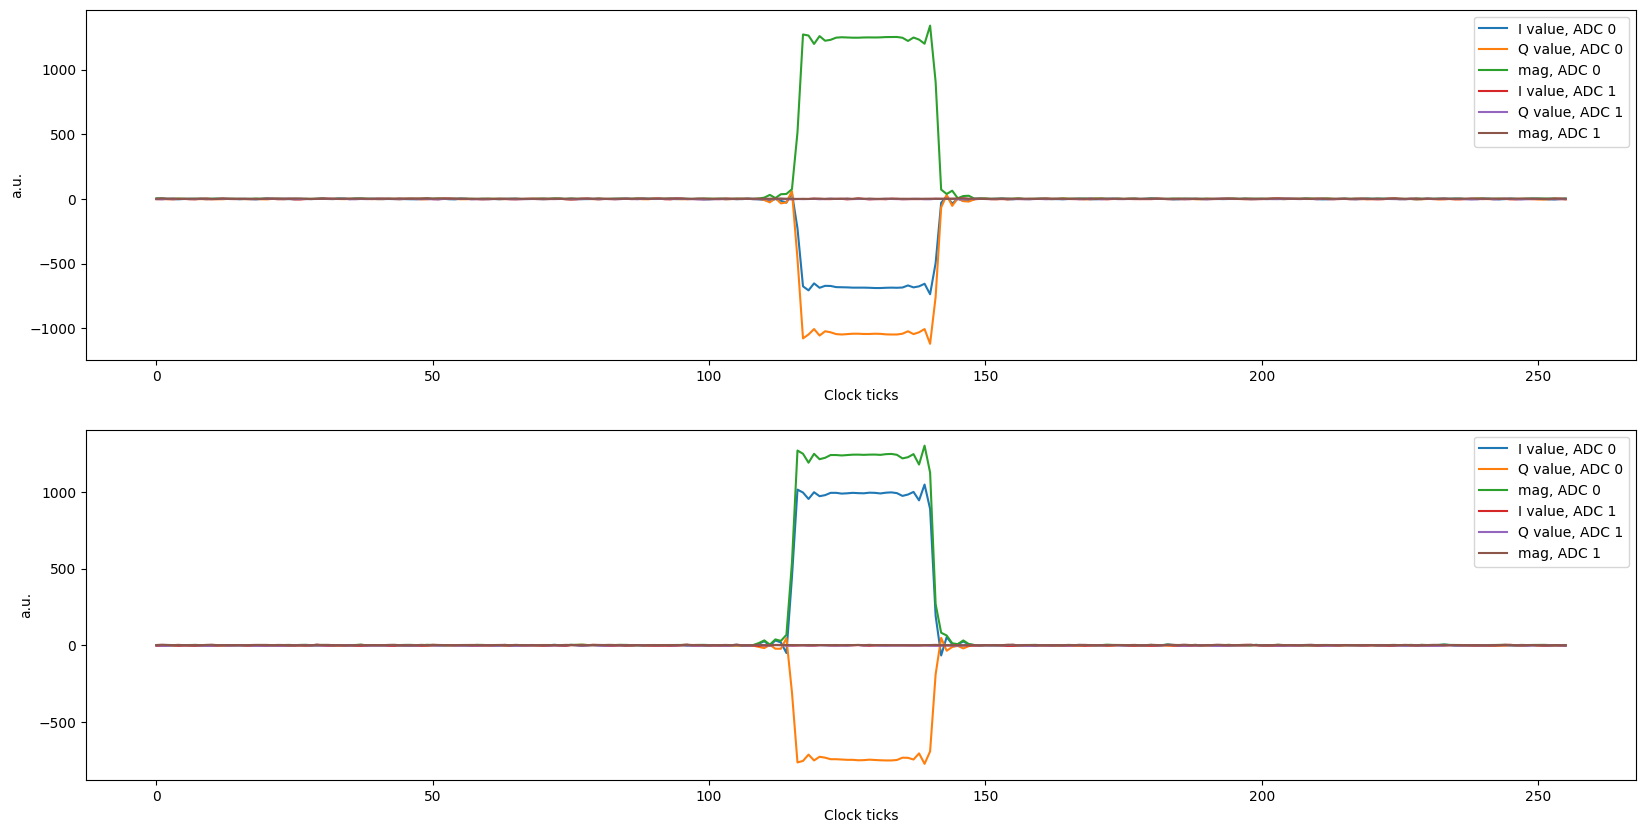

In [347]:
progs = []
config['send_start'] = True
for i, (soc, soccfg) in enumerate(proxies):
    progs.append(LoopbackProgramV2(soccfg, reps=1, final_delay=0.5, cfg=config))
    
iq_lists = []
for i, (soc, soccfg) in enumerate(proxies):
    iq_lists.append(progs[i].acquire_decimated(soc, progress=True))

fig, axes = plt.subplots(len(iq_lists), 1, figsize=(20,10))
for i, iq_list in enumerate(iq_lists):
    plot = axes[i]
    for ii, iq in enumerate(iq_list):
        plot.plot(iq[:,0], label="I value, ADC %d"%(config['ro_chs'][ii]))
        plot.plot(iq[:,1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
        plot.plot(np.abs(iq.dot([1,1j])), label="mag, ADC %d"%(config['ro_chs'][ii]))
    plot.set_ylabel("a.u.")
    plot.set_xlabel("Clock ticks")
    # plot.set_title("Averages = " + str(config["soft_avgs"]))
    plot.legend();

### synchronized

waiting to start leader
follower ready


  0%|          | 0/1 [00:00<?, ?it/s]

starting leader


  0%|          | 0/1 [00:00<?, ?it/s]

follower done
leader done


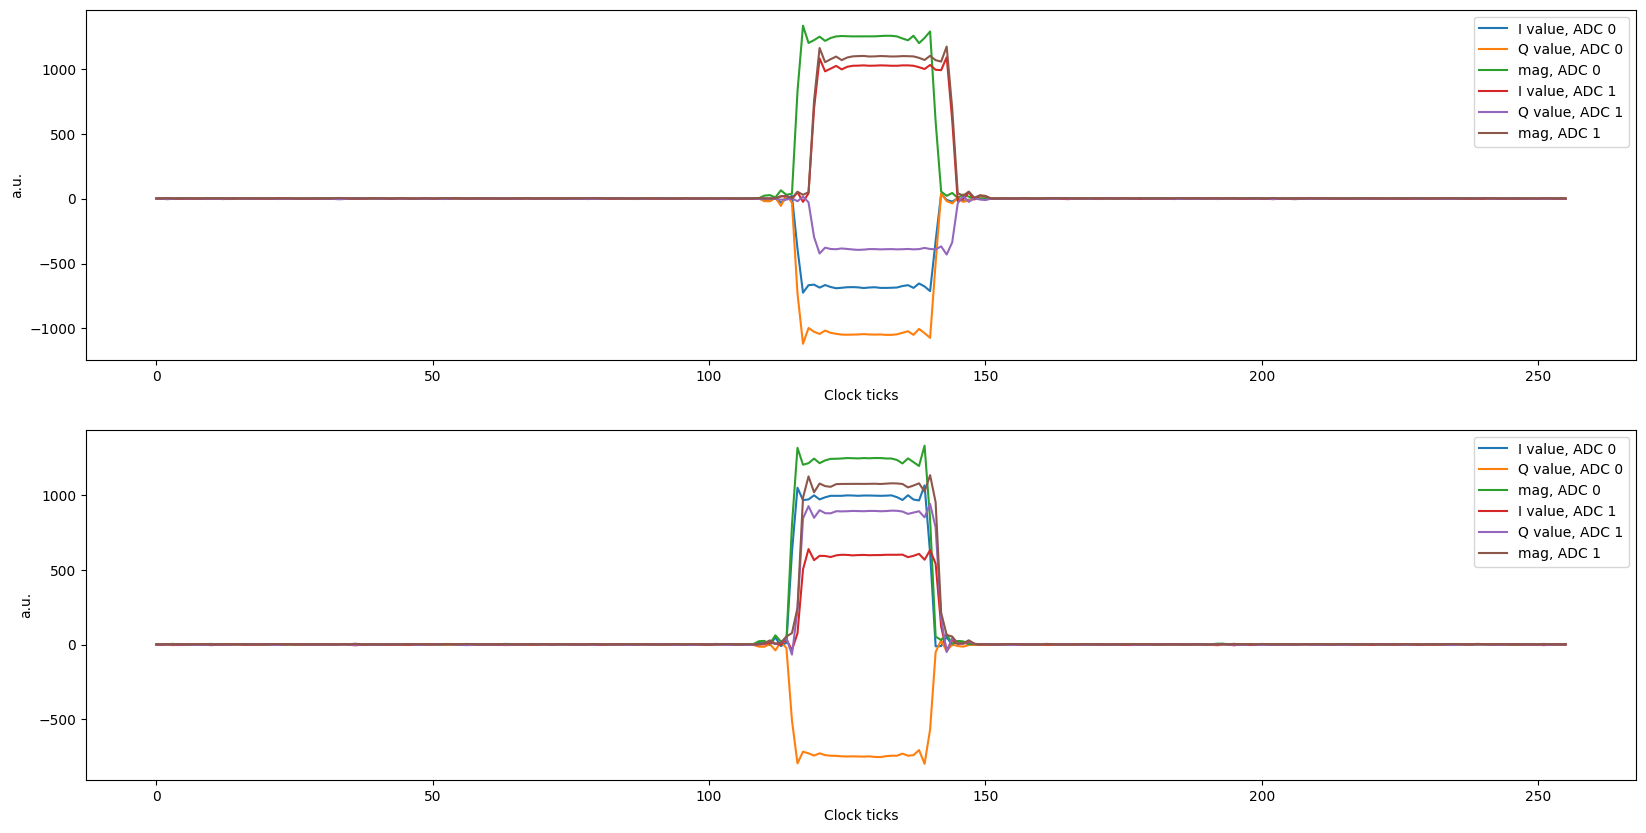

In [352]:
config['leader_delay'] = soccfg.cycles2us(20)

progs = []
for i, (soc, soccfg) in enumerate(proxies):
    config['send_start'] = (i==0)
    progs.append(LoopbackProgramV2(soccfg, reps=1, final_delay=0.5, cfg=config))

iq_lists = asyncio.run(run_multiboard())

fig, axes = plt.subplots(len(iq_lists), 1, figsize=(20,10))
for i, iq_list in enumerate(iq_lists):
    plot = axes[i]
    for ii, iq in enumerate(iq_list):
        plot.plot(iq[:,0], label="I value, ADC %d"%(config['ro_chs'][ii]))
        plot.plot(iq[:,1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
        plot.plot(np.abs(iq.dot([1,1j])), label="mag, ADC %d"%(config['ro_chs'][ii]))
    plot.set_ylabel("a.u.")
    plot.set_xlabel("Clock ticks")
    # plot.set_title("Averages = " + str(config["soft_avgs"]))
    plot.legend();